In [19]:
import pandas as pd
import glob
import collections
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [20]:
pxp = []
cols = ['down', 'yardLine', 'distance', 'type']
for year in range(2001, 2018):
    files = glob.glob('Improved-NCAA-Football-Data/{}PXP/*.csv'.format(year))
    for file in files:
        plays = pd.read_csv(file, usecols = cols)
        pxp.append(plays)
        
pxp = pd.concat(pxp)
pxp.rename(index=str, columns={'yardLine': 'yrdline100', 'distance': 'ydstogo', 'type': 'PlayType'}, inplace=True)
pxp = pxp.loc[(pxp['down'] == 4) & (pxp['PlayType'] != 'No Play') & (pxp['PlayType'] != 'QB Kneel')]
pxp['down'] = pxp['down'].apply(lambda down: int(down))
pxp['yrdline100'] = pxp['yrdline100'].apply(lambda yd: int(yd))
pxp['ydstogo'] = pxp['ydstogo'].apply(lambda yd: int(yd))

In [21]:
# Dictionary representing yard line on field mapped to another dictionary which maps yard line until 1st down mapped to another
# dictionary which maps play type to frequency
def getMapping(condensed=True):
    mapping = {}
    for index, row in pxp.iterrows():
        yrdline100 = row['yrdline100']
        ydstogo = row['ydstogo']
        playtype = row['PlayType']
        if condensed:
            if playtype != 'Field Goal' and playtype != 'Punt':
                playtype = 'Go For It'
        if yrdline100 in mapping:
            ydstogomapping = mapping[yrdline100]
            if ydstogo in ydstogomapping:
                playtypefreq = ydstogomapping[ydstogo]
                if playtype in playtypefreq:
                    playtypefreq[playtype] += 1
                else:
                    playtypefreq[playtype] = 1
            else:
                ydstogomapping[ydstogo] = {}
                playtypefreq = ydstogomapping[ydstogo]
                playtypefreq[playtype] = 1
        else:
            mapping[yrdline100] = {}
            ydstogomapping = mapping[yrdline100]
            ydstogomapping[ydstogo] = {}
            playtypefreq = ydstogomapping[ydstogo]
            playtypefreq[playtype] = 1
    return mapping

In [22]:
mapping = getMapping()
mapping = dict(collections.OrderedDict(sorted(mapping.items())))

In [23]:
def playfrequency(ydstogo, yrdLine):
    if yrdLine <= 0 or yrdLine >= 100:
        raise ValueError('Invalid yard line')
    if ydstogo not in mapping[yrdLine]:
        raise ValueError('No plays 4th and ' + str(ydstogo) + ' at the ' + str(yrdLine) + ' yard line')
    
    playfrequencies = mapping[yrdLine][ydstogo]
    playTypes = ['Go For It', 'Punt', 'Field Goal']
    frequency = []

    if 'Go For It' in playfrequencies:
        frequency.append(playfrequencies['Go For It'])
    else:
        frequency.append(0)
            
    if 'Punt' in playfrequencies:
        frequency.append(playfrequencies['Punt'])
    else:
        frequency.append(0)
        
    if 'Field Goal' in playfrequencies:
        frequency.append(playfrequencies['Field Goal'])
    else:
        frequency.append(0)


    plt.bar(playTypes, frequency)
    plt.xlabel('Play Type')
    plt.ylabel('Frequency')
    plt.title('4th and ' + str(ydstogo) + ' at the ' + str(yrdLine) + ' yard line')
    
    plt.show()
            
    return playfrequencies

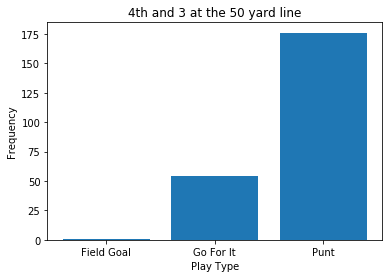

{'Field Goal': 1, 'Go For It': 54, 'Punt': 176}

In [24]:
playfrequency(3, 50)

In [25]:
df = pd.DataFrame(mapping)

In [26]:
mostcommon = df.applymap(lambda dct: max(dct, key=lambda k: dct[k]) if type(dct) == dict else '')

In [27]:
cmap = plt.cm.magma

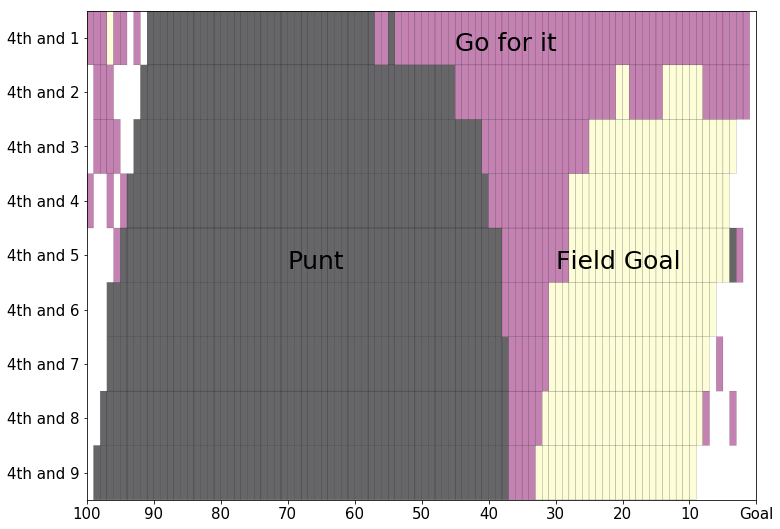

In [28]:
data = np.zeros((9, 99))
for i in range(9):
    for j in range(99):
        decision = mostcommon.loc[i + 1, j + 1]
        if decision == 'Punt':
            val = 0
        elif decision == 'Go For It':
            val = 5
        elif decision == 'Field Goal':
            val = 10
        else:
            val = np.nan
        data[i, j] = val
data = data[::-1,::-1]

fig, ax = plt.subplots(figsize=(12, 9))

ax.pcolor(
    data,
    vmin = 1,
    vmax = 10,
    edgecolors='k', 
    linewidths=.2,
    cmap=cmap,
    alpha=.6
);
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_xticklabels(['100', '90', '80', '70', '60', '50', '40', '30', '20', '10', 'Goal'])
ax.set_yticks([yd - .5 for yd in range(1, 10)])
ax.set_yticklabels(['4th and {}'.format(yd) for yd in range(9, 0, -1)])
ax.text(55, 8.25, 'Go for it', size=25)
ax.text(30, 4.25, 'Punt', size=25)
ax.text(70, 4.25, 'Field Goal', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

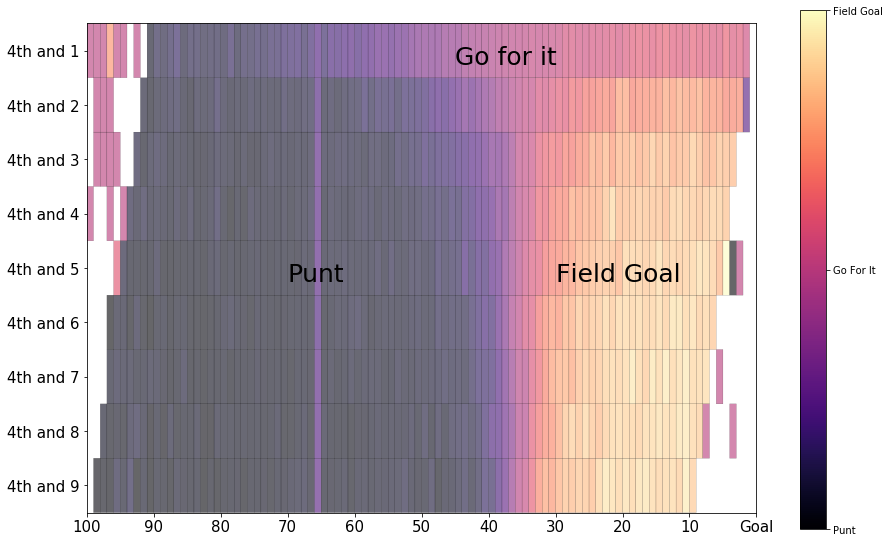

In [29]:
data = np.zeros((9, 99))
for i in range(9):
    for j in range(99):
        playfrequencies = df.loc[i + 1, j + 1]
        if type(playfrequencies) == dict:
            if 'Punt' in playfrequencies:
                punt = playfrequencies['Punt']
            else:
                punt = 0
                
            if 'Go For It' in playfrequencies:
                goforit = playfrequencies['Go For It']
            else:
                goforit = 0

            if 'Field Goal' in playfrequencies:
                fieldgoal = playfrequencies['Field Goal']
            else:
                fieldgoal = 0
            
            total = goforit + punt + fieldgoal
            goforit = goforit / total
            punt = punt / total
            fieldgoal = fieldgoal / total
            val = 5 + punt * -5 + fieldgoal * 5
        else:
            val = np.nan
        data[i, j] = val
data = data[::-1,::-1]

fig, ax = plt.subplots(1, 1, figsize=(12, 9))

ax.pcolor(data, edgecolors='k', linewidths=.2, cmap=cmap, alpha=.6)
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_xticklabels(['100', '90', '80', '70', '60', '50', '40', '30', '20', '10', 'Goal'])
ax.set_yticks([yd - .5 for yd in range(1, 10)])
ax.set_yticklabels(['4th and {}'.format(yd) for yd in range(9, 0, -1)])
ax.text(55, 8.25, 'Go for it', size=25)
ax.text(30, 4.25, 'Punt', size=25)
ax.text(70, 4.25, 'Field Goal', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)

ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, ticks=[0, 0.5, 1])
cb.ax.set_yticklabels(['Punt', 'Go For It', 'Field Goal']) 

plt.show()